In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import os
os.environ['MLFLOW_TRACKING_USERNAME']='hatemhellal'
os.environ["MLFLOW_TRACKING_PASSWORD"]="fb488a04e3aeea8a886af3ee695779672de939ea"

In [3]:
train = pd.read_csv('./fraudTrain.csv')

In [4]:
len(train)

1296675

In [5]:
train_100k=train.iloc[:100000,:]

In [6]:
#train_100k.to_csv(r"C:\\Users\\hatem\\OneDrive\\Desktop\\3idsd-id\\mlops\\data\\train_100k.csv",index=False)

In [7]:
df=pd.read_csv(".\\train_100k.csv")

In [8]:
df['trans_date_trans_time']=pd.to_datetime(df['trans_date_trans_time'])
df['trans_date']=df['trans_date_trans_time'].dt.strftime('%Y-%m-%d')
df['trans_date']=pd.to_datetime(df['trans_date'])
df['dob']=pd.to_datetime(df['dob'])

In [9]:
df.drop("Unnamed: 0",axis=1,inplace=True)
df.drop(['trans_date_trans_time','first', 'last', 'dob'] , axis=1, inplace=True)

In [10]:
df['trans_month'] = pd.DatetimeIndex(df['trans_date']).month
df['trans_year'] = pd.DatetimeIndex(df['trans_date']).year


In [11]:
import calendar
df['Month_name'] = df['trans_month'].apply(lambda x: calendar.month_abbr[x])

In [12]:
l=["merchant","category","gender","street","city","state","job","trans_num","trans_date","Month_name"]
df=df.drop(l,axis=1)

c:\Users\hatem\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0.5, 1.0, ' not Fraud=0 fraud=1')

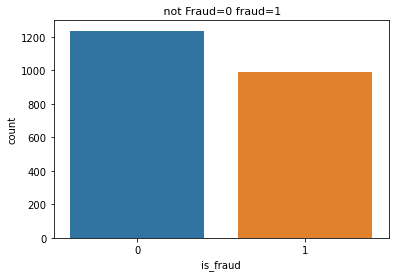

In [13]:
from imblearn.under_sampling import RandomUnderSampler
undersample = RandomUnderSampler(sampling_strategy=0.8)
feature_columns = list(df.columns.drop('is_fraud'))
X = df[feature_columns]
y = df["is_fraud"]
X_balanced, Y_balanced = undersample.fit_resample(X, y)
df_fraud = X_balanced 
df_fraud["is_fraud"] = Y_balanced 

y_balance = pd.DataFrame(Y_balanced, columns =["is_fraud"])
sns.countplot('is_fraud', data=y_balance ) 
plt.title(' not Fraud=0 fraud=1', fontsize=11) 


In [14]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
def data_preprocess(dataframe):
    dataframe=dataframe.dropna()
    dataframe.fillna(dataframe.mean(),inplace=True)
    dataframe=dataframe.reset_index()
    minmaxscaler=MinMaxScaler()
    dataframe.amt-=dataframe.amt.mean(axis=0)
    dataframe.amt/=dataframe.amt.std(axis=0)
    return dataframe



In [15]:
def get_train_test(dataframe,feature_columns,target_column,train_test_split_ratio,random_seed):
    X=dataframe[feature_columns]
    y=dataframe[target_column]
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=train_test_split_ratio, random_state=random_seed)
    return X_train, X_test, y_train, y_test


In [16]:
config={
    'feature_columns':feature_columns,
    'target_column':["is_fraud"],
    'random_seed':42,
    'train_test_split_ratio':0.8

}

In [17]:
df_fraud

,cc_num,amt,zip,lat,long,city_pop,unix_time,merch_lat,merch_long,trans_month,trans_year,is_fraud
0,372520049757633,71.87,56668,48.6031,-93.2977,136,1325954618,48.663678,-93.055988,1,2019,0
1,4810839835482793984,7.60,64874,36.7651,-94.0492,760,1329684274,37.152049,-94.715580,2,2019,0
2,6011360759745864,2.68,22824,38.8432,-78.6003,6018,1330282506,38.080189,-78.787689,2,2019,0
3,30518196150127,58.04,60963,40.3625,-87.6692,1807,1326310564,40.828580,-88.572775,1,2019,0
4,4294930380592,34.73,24070,37.3696,-80.1284,1363,1329927742,37.775142,-80.603287,2,2019,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2222,4642894980163,779.79,51632,40.7491,-95.0380,7297,1330393370,40.177856,-94.103864,2,2019,1
2223,30074693890476,11.11,67851,37.9931,-100.9893,2691,1330397485,38.023713,-100.035305,2,2019,1
2224,630425673344,289.23,24927,38.3880,-79.9906,365,1330400469,38.943533,-79.546329,2,2019,1
2225,4642894980163,9.07,51632,40.7491,-95.0380,7297,1330402000,39.987059,-95.041018,2,2019,1


In [18]:
df=df_fraud
df=data_preprocess(df)
X_train, X_test, y_train, y_test=get_train_test(df,config['feature_columns'],config['target_column'],config['train_test_split_ratio'],config['random_seed'])

In [19]:
import mlflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
#Create a Gaussian Classifier
clf=RandomForestClassifier(n_estimators=100)
clf.fit(X_train,y_train)
accuracy= cross_val_score(clf, X_train, y_train).mean()
print(accuracy)

C:\Users\hatem\AppData\Local\Temp/ipykernel_10784/2905068467.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train,y_train)
C:\Users\hatem\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\hatem\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\hatem\AppData\Roaming\Python\Python39\site-packages\sklearn\model_selection\_validation.py:686: DataConversionWarning: A colum

0.9309397916469958


In [20]:
mlflow.sklearn.autolog(registered_model_name="RandomForest")

In [23]:
from sklearn.metrics import recall_score
RUN_NAME='RandomForest'
with mlflow.start_run(run_name=RUN_NAME):
    clf=RandomForestClassifier(n_estimators=100)
    clf.fit(X_train,y_train)
    y_pred =clf.predict(X_test)
    accuracy= cross_val_score(clf, X_train, y_train).mean()
    recall=recall_score(y_test,y_pred)
    mlflow.log_metric("accuracy", accuracy)
    mlflow.log_metric("recall", recall)
    

2022/09/26 09:26:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\hatem\anaconda3\lib\site-packages\mlflow\utils\autologging_utils\safety.py:533: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel()."
2022/09/26 09:26:45 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\hatem\anaconda3\lib\site-packages\mlflow\models\signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when

In [ ]:
'''from sklearn.metrics import recall_score
with mlflow.start_run():
    clf=RandomForestClassifier(n_estimators=100)
    clf.fit(X_train,y_train)
    y_pred =clf.predict(X_test)
    accuracy= cross_val_score(clf, X_train, y_train).mean()
    recall=recall_score(y_test,y_pred)
    mlflow.log_param("accuracy", accuracy)
    mlflow.log_param("recall", recall)'''

2022/09/25 18:00:29 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\hatem\anaconda3\lib\site-packages\mlflow\utils\autologging_utils\safety.py:533: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel()."
2022/09/25 18:00:30 WARNING mlflow.utils.autologging_utils: MLflow autologging encountered a warning: "c:\Users\hatem\anaconda3\lib\site-packages\mlflow\models\signature.py:129: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) when